# Tarea - Probabilidad, Ajuste de Modelos y MC

El archivo "data.txt" muestra la distribución de la gente en un andén del metro a lo largo de un día. La estación del metro tiene tres entradas al andén colocadas a 30, 70 y 120 metros, respecto del inicio del andén, el cual mide 150 metros en total.

La distribución se obtuvo contando a todas las personas distribuidas cada 1 metro de principio a fin. De esta forma se obtiene la siguiente distribución con 150 "bins".

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math # Formato LaTeX en print
# LaTeX
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

data = np.loadtxt("data.txt",unpack=True)
binscenters  = data[0] # Centro de los bins
muestra      = data[1] # Datos de la distribución
bin_width    = 1 # El conteo se hace cada 1 metro

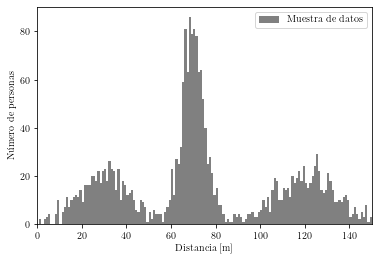

In [2]:
plt.bar(binscenters, muestra, width=bin_width, color='gray', label=r'Muestra de datos')
plt.xlabel("Distancia [m]")
plt.ylabel("Número de personas")
plt.xlim(0,150)
plt.legend()

Esta distribución es una muestra representativa de lo que sucede todos los días a lo largo del año, pero sigue siendo sólo un día el que se muestra. Lo ideal sería realizar el conteo durante todos los días para así tener un estimado de la distribución en el año. Sin embargo, esto último resulta imposible, al menos en la práctica.

Preguntas:

- ¿Cuántas personas hubo en la estación ese día?
- ¿Cuál es la probabilidad de encontrar 1 persona entre los 100 y 110 metros de la estación durante este día?
- ¿Podrías estimar de alguna forma cuál sería la probabilidad de encontrar 1 persona entre los 100 y 110 metros, pero durante todo el año?
- ¿Cuál es la posición más probable para encontrar a una persona (valor esperado) en el día? ¿Y a lo largo del año?

Tips:

1) Supón todo lo que tengas que suponer, pero arguméntalo.

2) Usa cualquiera de las cosas que hayamos visto (checa los notebooks Probabilidad.ipynb, Pi_Estimation.ipynb, Ajuste de Modelo - MC.ipynb).

3) Es conveniente ajustar un modelo a los datos.

4) Nota que la distribución que tienes no está normalizada, por lo que no es una PDF todavía.

5) Recuerda que 
$$ 
\int_0^{150} p(x) \, \mathrm{d}x = 1.
$$
6) Calcula la función acumulativa (CDF). Esta función debe valer 1 en 150, con esto sabrás si tu PDF está bien normalizada.

7) Para las preguntas sobre cuál sería la probabilidad a lo largo del año, te recomiendo realizar 365 simulaciones Monte Carlo (una por cada día del año) asumiendo una distribución que se acople a los datos que tienes (punto 3) y obteniendo una muestra distinta (sample, distribución) de N personas para cada día. Puedes asumir que cada día hay la misma cantidad N de personas o, si quieres, asumir una forma más complicada como, por ejemplo, que en días festivos no hay tanta gente como en un viernes de quincena.

## 1) ¿Cuántas personas hubo en la estación ese día?

Sumamos todas las personas de la distribución.

In [3]:
Num_personas = 0
for i in range(len(muestra)):
    Num_personas += muestra[i]
    
print("")
display(Math(r'\text{{El número de personas en el ánden a lo largo del día es:}} \, \, N = {:.0f}'.format(Num_personas)))

<IPython.core.display.Math object>

## 2) ¿Cuál es la probabilidad de encontrar 1 persona entre los 100 y 110 metros de la estación durante este día?

Calculemos primero la distribución de probabilidad PDF. Para esto tenemos que normalizar nuestra muestra de datos.

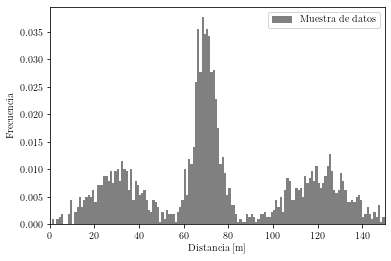

In [4]:
pdf = muestra/Num_personas
plt.bar(binscenters, pdf, width=bin_width, color='gray', label=r'Muestra de datos')
plt.xlabel("Distancia [m]")
plt.ylabel("Frecuencia")
plt.xlim(0,150)
plt.legend()

Para calcular la probabilidad de encontrar a alguien entre los 100 y 110 metros, realizamos la integración de la PDF entre estos dos valores:

In [5]:
prob = 0

xmin = 100
xmax = 110

for i in range(len(pdf)):
    if binscenters[i] > xmin and binscenters[i] < xmax:
        prob += pdf[i]
        
display(Math(r'\text{{La probabilidad de encontrar a alguien entre los 100 y 110 metros es:}} \, \, Prob \approx {:.1f}\%'.format(prob*100)))

<IPython.core.display.Math object>

## Ajustando una distribución

Para hacer un cálculo más preciso, primero ajustemos una distribución. Dado a la forma que vemos, y al hecho de que la gente se comporta de manera normal, podríamos argumentar que una distribución que se le puede ajustar a la muestra es la suma de 3 Gaussianas.

In [6]:
from scipy.optimize import curve_fit

def fit_function(x, A, mu1, std1, B, mu2, std2, C, mu3, std3):
    return (A * np.exp(-1.0 * (x - mu1)**2/ (2 * std1**2)) + B * np.exp(-1.0 * (x - mu2)**2 / (2 * std2**2)) + C * np.exp(-1.0 * (x - mu3)**2/ (2 * std3**2)))

In [7]:
p0 = [0.1,30,1,0.1,70,1,0.1,120,1]
pfit, pcov = curve_fit(fit_function, xdata=binscenters, ydata=pdf, p0=p0)

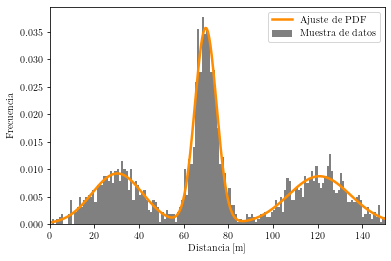

In [8]:
x = np.linspace(0,150,10000)

plt.bar(binscenters, pdf, width=bin_width, color='gray', label=r'Muestra de datos')
plt.plot(x,fit_function(x,*pfit),linewidth=2.5,color='darkorange',label='Ajuste de PDF')
plt.xlabel("Distancia [m]")
plt.ylabel("Frecuencia")
plt.xlim(0,150)
plt.legend()

Calculemos ahora la probabilidad con el fit:

In [9]:
# Array continuo
x = np.linspace(0,150,10000)
fit_pdf = fit_function(x,*pfit)
        
dumb = 0
prob = 0
for i in np.arange(len(x)):
    dumb += fit_pdf[i]*(x.max()-x.min())/len(x)
    if x[i] <= xmax and x[i] >= xmin:
        prob += fit_pdf[i]*(x.max()-x.min())/len(x)

display(Math(r'\text{{La probabilidad de encontrar a alguien entre los 100 y 110 metros es:}} \, \, Prob \approx {:.1f}\%'.format(prob*100)))

<IPython.core.display.Math object>

Calculemos ahora la CDF y a partir de la PDF y ploteemos ambas:

In [10]:
# Calculamos la CDF a partir de la distribución y normalizamos para obtener la PDF.
cdf = []
        
dumb = 0
for i in np.arange(len(x)):
    dumb += fit_pdf[i]*(x.max()-x.min())/len(x)
    cdf.append(dumb)

# Normalizamos nuestra distribución y calculamos PDF y CDF.
norm = dumb
fit_pdf = fit_pdf/norm
fit_cdf = np.array(cdf)/norm

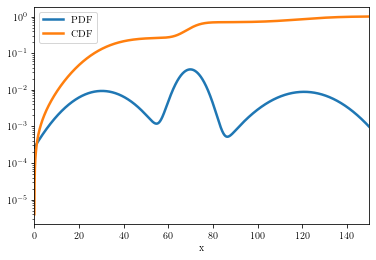

In [11]:
plt.semilogy(x,fit_pdf,linewidth=2.5,label='PDF')
plt.semilogy(x,fit_cdf,linewidth=2.5,label='CDF')
plt.xlim(0,150)
plt.xlabel("x")
plt.legend()

## 3) ¿Podrías estimar de alguna forma cuál sería la probabilidad de encontrar 1 persona entre los 100 y 110 metros, pero durante todo el año?

Ya tenemos el ajuste de la distribución a la muestra de datos. Lo que podemos hacer ahora es realizar 365 simulaciones MC (una por cada día del año), partiendo del ajuste inicial, pero variando los parámetros un poco.

Para esto necesitaremos obtener una serie de distintas muestras de datos simulados, a partir del modelo que ajustamos.

In [12]:
from scipy import interpolate

# Interpolamos de manera inversa para obtener F = CDF⁻¹
F = interpolate.interp1d(cdf,x,kind='cubic')

Definimos ahora el número de personas que habrá distribuiremos a lo largo del andén, usando el modelo ajustado. Vamos a suponer, por el momento, que este número de personas es el mismo que el que obtuvimos de los datos, i.e., $N$ = $N_{personas}$.

In [21]:
N = 5000
x_new = np.random.uniform(0.001,0.99,size=N)
sim = F(x_new)

bins  = np.linspace(0, 150, 151)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
muestra_sim, bins_cat = np.histogram(sim,bins=bins,density=False)

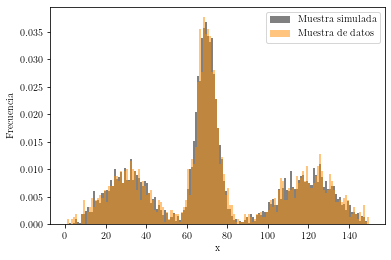

In [22]:
plt.bar(binscenters, muestra_sim/N, width=bin_width, color='gray', label=r'Muestra simulada')
plt.bar(binscenters, muestra/Num_personas, width=bin_width, color='darkorange', label=r'Muestra de datos',alpha=0.5)
plt.xlabel("x")
plt.ylabel("Frecuencia")
plt.legend()

Como repetiremos este proceso 365 veces, crearemos una función que nos regrese una muestra simulada ya normalizada:

In [23]:
def sim_sample(F,N):
    x_new = np.random.uniform(0.001,0.99,size=N)
    sim = F(x_new)
    
    bins  = np.linspace(0, 150, 151)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    muestra_sim, bins_cat = np.histogram(sim,bins=bins,density=False)
    
    return muestra_sim/N

Realicemos las simulaciones MC

In [24]:
N_sim = 365
FitParams = np.array([])

for i in range(N_sim):
    sim_pdf = sim_sample(F,N)
    p0      = pfit
    
    try:
        vsims, acova = curve_fit(fit_function, xdata=binscenters, ydata=sim_pdf, p0=p0)
    except:
        dumdum=1
        continue
    
    if np.size(FitParams) < 1:
        FitParams = np.copy(vsims)
    else:
        FitParams = np.vstack(( FitParams, vsims ))

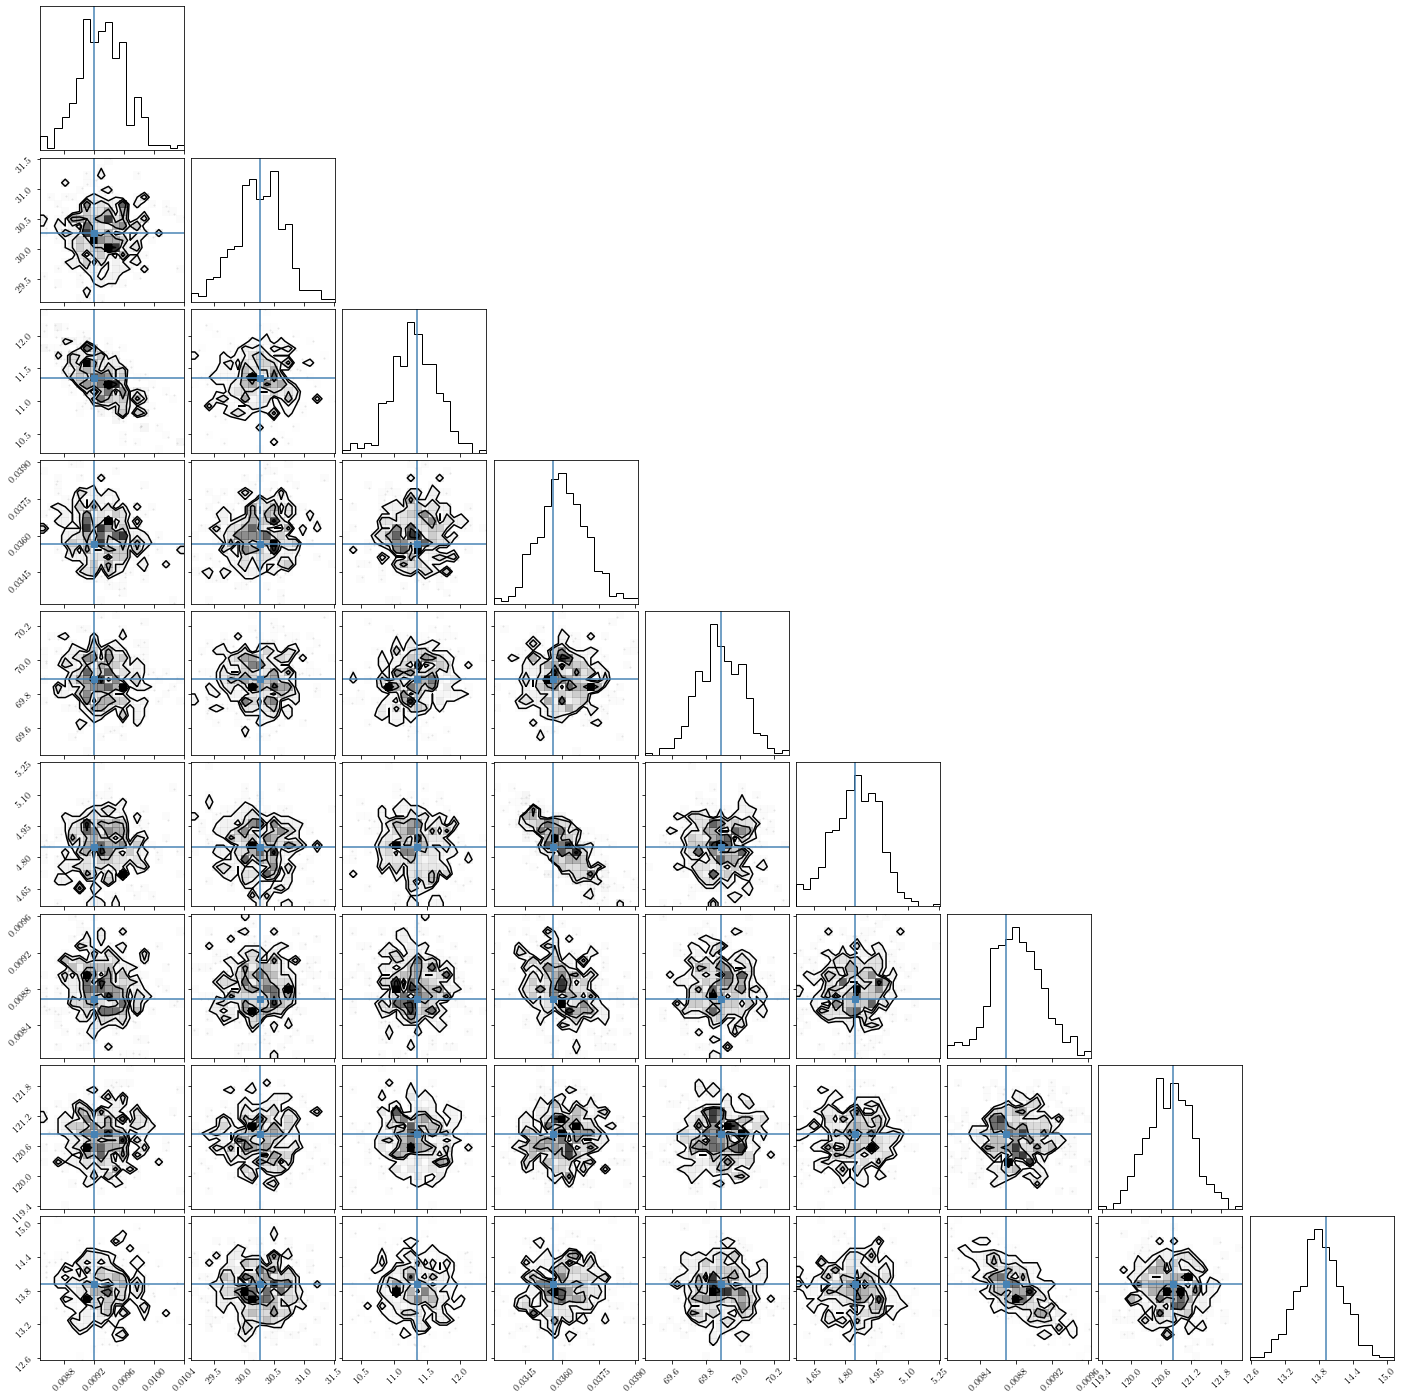

In [25]:
import corner

fig = corner.corner(
    FitParams, truths=pfit
);

De aquí podemos observar como algunos de los valores medios para los parámetros sí son diferentes a los del ajuste directo a los datos experimentales. Calculamos los valores medios de los parámetros, según las simulacioens MC, así como su desviación estándar.

In [26]:
med_fit = np.zeros(len(FitParams[0]))
std_fit = np.zeros(len(FitParams[0]))

for i in range(len(FitParams[0])):
    med_fit[i] = np.median(FitParams[:,i])
    std_fit[i] = np.std(FitParams[:,i])

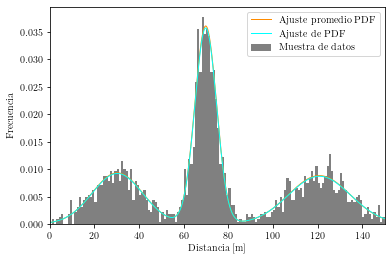

In [27]:
x = np.linspace(0,150,10000)

plt.bar(binscenters, pdf, width=bin_width, color='gray', label=r'Muestra de datos')
plt.plot(x,fit_function(x,*med_fit),linewidth=1,color='darkorange',label='Ajuste promedio PDF')
plt.plot(x,fit_function(x,*pfit),linewidth=1,color='cyan',label='Ajuste de PDF')
plt.xlabel("Distancia [m]")
plt.ylabel("Frecuencia")
plt.xlim(0,150)
plt.legend()

Como podemos ver no hay una diferencia significativa entre el ajuste inicial que le hicimos a los datos, y el promedio obtenido de las simulaciones MC.

In [34]:
from scipy.optimize import minimize

In [28]:
def log_likelihood(theta,x,y):
    A, mu1, std1, B, mu2, std2, C, mu3, std3, log_f = theta
    model = fit_function(x, A, mu1, std1, B, mu2, std2, C, mu3, std3)
    sigma2 = model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [57]:
nll = lambda *args: -log_likelihood(*args)
initial = np.array([*pfit, np.log(0.01)]) + 0.0001 * np.random.randn(10)
soln = minimize(nll, initial, args=(binscenters, pdf))

In [58]:
soln.x[0:9]

array([7.97885049e-03, 2.96392917e+01, 1.26989554e+01, 3.05766439e-02,
       7.01734329e+01, 5.21411010e+00, 7.57689901e-03, 1.20860612e+02,
       1.54675124e+01])

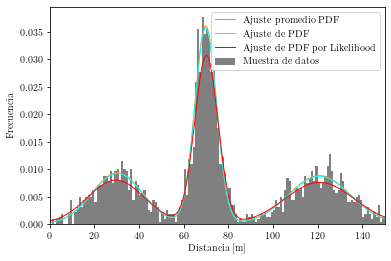

In [60]:
x = np.linspace(0,150,10000)

plt.bar(binscenters, pdf, width=bin_width, color='gray', label=r'Muestra de datos')
plt.plot(x,fit_function(x,*med_fit),linewidth=1,color='darkorange',label='Ajuste promedio PDF')
plt.plot(x,fit_function(x,*pfit),linewidth=1,color='cyan',label='Ajuste de PDF')
plt.plot(x,fit_function(x,*soln.x[0:9]),linewidth=1,color='red',label='Ajuste de PDF por Likelihood')
plt.xlabel("Distancia [m]")
plt.ylabel("Frecuencia")
plt.xlim(0,150)
plt.legend()

In [61]:
pfit

array([9.19279599e-03, 3.02736311e+01, 1.13553323e+01, 3.56381739e-02,
       6.98898928e+01, 4.84875919e+00, 8.68937013e-03, 1.20833104e+02,
       1.39191050e+01])

In [62]:
def log_prior(theta):
    A, mu1, std1, B, mu2, std2, C, mu3, std3, log_f = theta
    if 0.0001 < A < 0.1 and 20 < mu1 < 40 and 0 < std1 < 20 and 0.0001 < B < 0.1 and 60 < mu2 < 80 and 0 < std2 < 20 and 0.0001 < C < 0.1 and 100 < mu3 < 140 and 0 < std3 < 20 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

In [63]:
def log_probability(theta, x, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y)

In [65]:
# La MLE es soln.x. 32 caminantes aleatorios y 3 parámetros del modelo
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 10)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(binscenters, pdf))
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [00:10<00:00, 476.83it/s]


State([[ 8.38361331e-03  2.91640451e+01  1.25562952e+01  2.97494519e-02
   7.01850243e+01  5.28284886e+00  7.86297825e-03  1.21440574e+02
   1.55443334e+01 -9.85661012e-01]
 [ 7.74990523e-03  2.94800894e+01  1.26630158e+01  3.06414656e-02
   6.99686706e+01  5.30708215e+00  7.93053532e-03  1.21231873e+02
   1.54779277e+01 -8.78165547e-01]
 [ 7.38358351e-03  2.96755049e+01  1.25963528e+01  3.08156328e-02
   7.03895483e+01  5.23486634e+00  8.10628722e-03  1.20937519e+02
   1.48602728e+01 -9.74522513e-01]
 [ 7.93955590e-03  2.96170691e+01  1.24932593e+01  2.72156693e-02
   7.03122750e+01  5.40226809e+00  7.96861729e-03  1.20752647e+02
   1.53859462e+01 -9.57641930e-01]
 [ 7.75083015e-03  2.89199375e+01  1.34404398e+01  2.92241435e-02
   7.02006735e+01  5.41869769e+00  7.69230080e-03  1.21344487e+02
   1.55526068e+01 -9.47287925e-01]
 [ 9.39120577e-03  2.97726012e+01  1.21088752e+01  2.87913487e-02
   7.01917977e+01  5.31859943e+00  7.37224512e-03  1.21426506e+02
   1.52353526e+01 -8.729403

In [66]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 10)


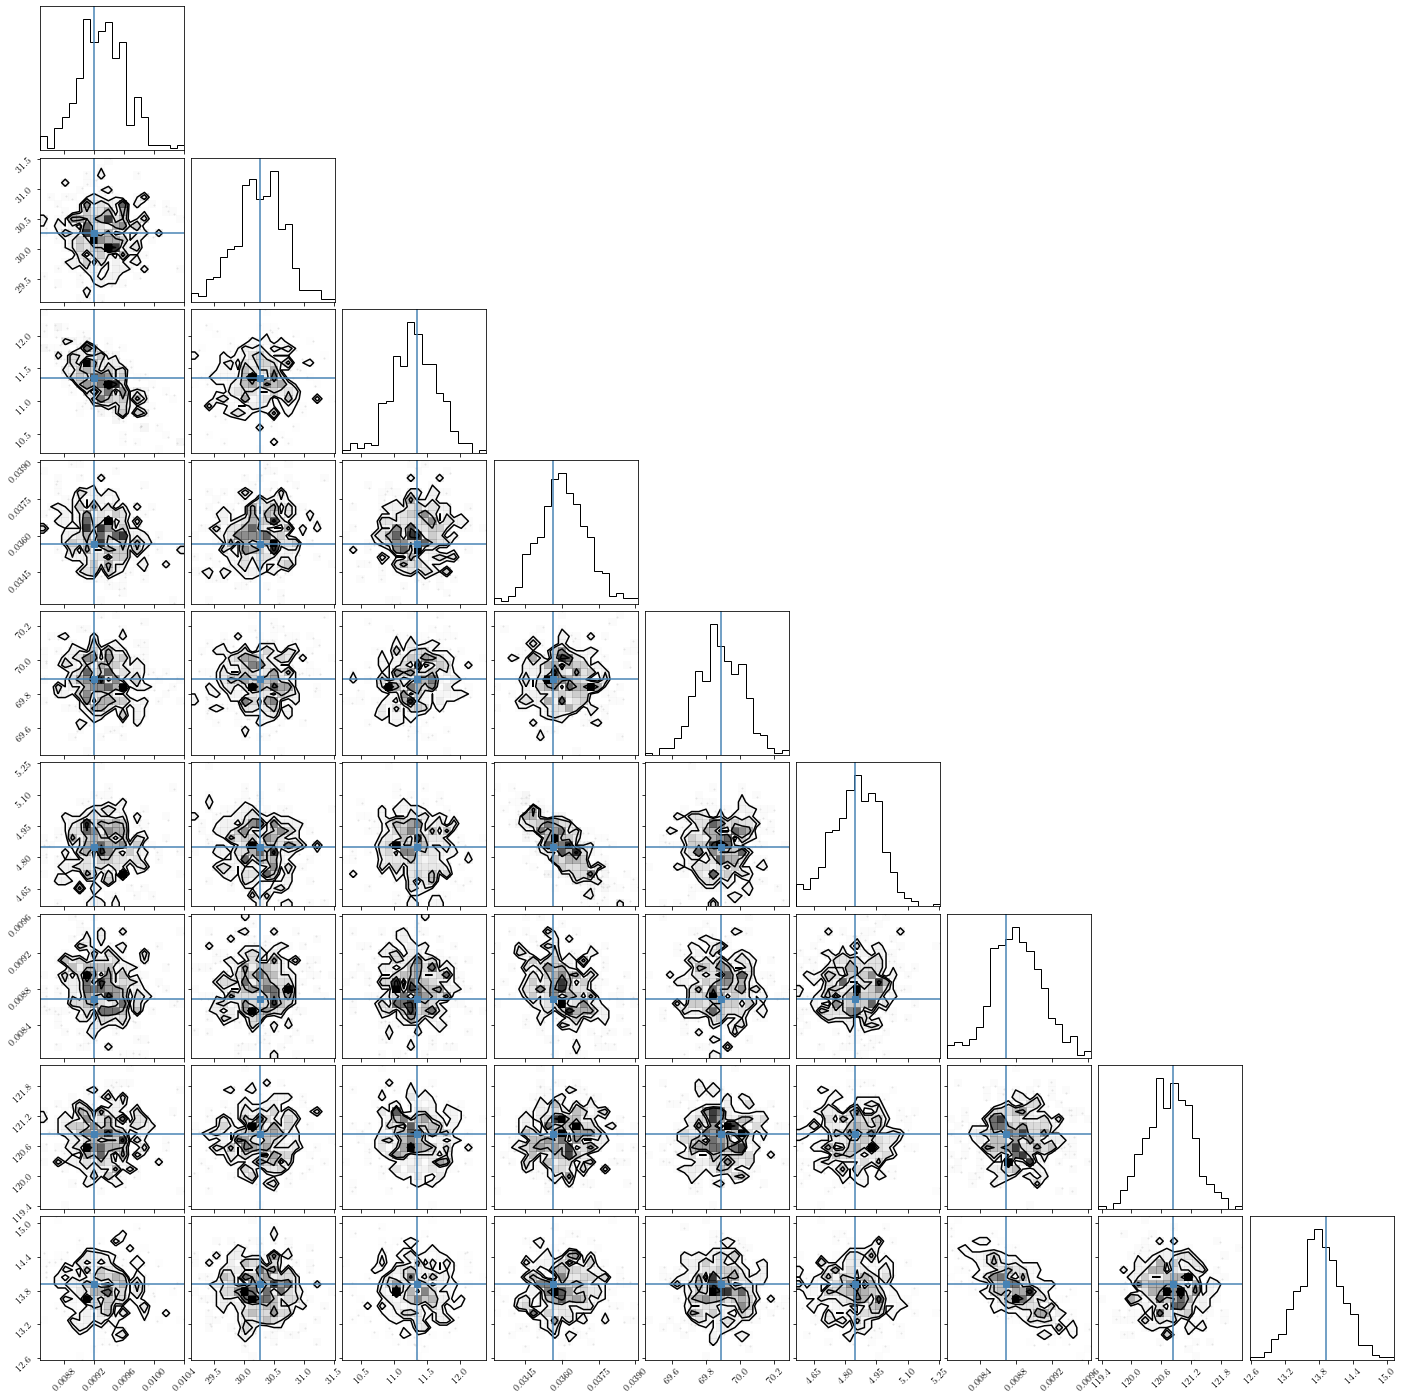

In [67]:
fig = corner.corner(
    FitParams, truths=pfit
);

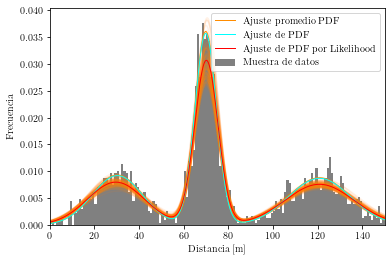

In [72]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x,fit_function(x,*sample[0:9]),"C1",alpha=0.1)

plt.bar(binscenters, pdf, width=bin_width, color='gray', label=r'Muestra de datos')
plt.plot(x,fit_function(x,*med_fit),linewidth=1,color='darkorange',label='Ajuste promedio PDF')
plt.plot(x,fit_function(x,*pfit),linewidth=1,color='cyan',label='Ajuste de PDF')
plt.plot(x,fit_function(x,*soln.x[0:9]),linewidth=1,color='red',label='Ajuste de PDF por Likelihood')
plt.xlabel("Distancia [m]")
plt.ylabel("Frecuencia")
plt.xlim(0,150)
plt.legend()